# Model hiper optimization

In [83]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [87]:
def predict_proba_range(y, start=0, end=1, step=0.05, normalize=False):
    # generator
    bins = list(map(lambda x: (round(x, 2), round(x+step, 2)), np.arange(start, end, step)))
    # adapt to contemplate equal to 0
    bins[0] = ((start-0.01), step)
    # convert in IntervalIndex to use pandas.cut
    bins = pd.IntervalIndex.from_tuples(bins)
    return pd.cut(y, bins).value_counts(dropna=False).sort_index()
 
def plot_predict_proba_range(range_predict, exclude=None):
    """Bar plot range predictions.

    Parameters
    ----------
    range_predict: pd.Series
       sorted range and distribution.

    exclude: {'left', 'right', 'both', None} (default: None)
       avoids plot extremes {'left', 'right', 'both', None}.
           left: avoids lower extreme,
           right: avoids upper extreme,
           both: avoids lower and upper extreme,
           None: shows all.

    """
    # TODO: ADD ascending or descending order
    left, right = None, None
    if exclude in ["left", "both"]:
       left = 1
    if exclude in ["right", "both"]:
       right = -1
    range_pred.iloc[left:right].plot.barh()

In [85]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0.b - 6m total_condiciones_split_gte_4 with ZONE GROUPS without comp_cond and time_cond"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [4]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [5]:
# using only last year
# split_date = "2018-01-01"
# df = df[df["FECHA_SINI"] >= split_date].copy()

In [6]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [7]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,983521,1705
1.0,44395,162
2.0,9329,216
3.0,42457,478
4.0,3258,35
5.0,2940,718
6.0,1314,94
7.0,219,99
8.0,203,80


In [8]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[(df["total_condicion"] >= 4)]
df_val = df_val[(df_val["total_condicion"] >= 4)]

In [9]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
4.0,3258,35
5.0,2940,718
6.0,1314,94
7.0,219,99
8.0,203,80
9.0,28,4
10.0,61,44
11.0,6,2
12.0,9,8


In [10]:
df["TIPO_EXPED"].value_counts()

6    2634
5    2056
1    1849
7    1281
3     590
2     564
0     147
4      18
Name: TIPO_EXPED, dtype: int64

In [11]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [12]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11', 'cond_12',
       'cond_32', 'cond_37', 'cond_C1', 'cond_C10', 'cond_C11', 'cond_C12',
       'cond_C13', 'cond_C14', 'cond_C15', 'cond_C16', 'cond_C17', 'cond_C18',
       'cond_C19', 'cond_C2', 'cond_C20', 'cond_C21', 'cond_C3', 'cond_C4',
       'cond_C5', 'cond_C6', 'cond_C7', 'cond_C8', 'cond_C9'],
      dtype='object')

In [13]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [14]:
df["cant_cond"].value_counts()

2    7012
1    1476
3     617
4      33
5       1
Name: cant_cond, dtype: int64

In [15]:
df["EXISTE_FRAUDE"].value_counts()

False    8048
True     1091
Name: EXISTE_FRAUDE, dtype: int64

In [16]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [17]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [18]:
pd.crosstab(df["FECHA_SINI"].dt.month, [df["EXISTE_FRAUDE"], df["TIPO_EXPED"]], margins=True)

EXISTE_FRAUDE False                                 True                All
TIPO_EXPED        0     1    2    3   4     5     6    1  3   5     6      
FECHA_SINI                                                                 
1.0              23   199   73   51   1   211   367    1  0  11   206  1143
2.0              16   131   20    3   0    98    64    0  0   5    34   371
3.0              10   117   31    1   0   101    57    0  0   1    40   358
4.0              13   139   31    0   2   106    48    0  0   8    31   378
5.0               9   127   32    3   1   119    94    1  0   7    47   440
6.0              16   147   32    0   0   128   119    0  0  10    52   504
7.0              17   133   45    7   2   190   162    0  0   6    97   659
8.0              12   155   29   22   2   191   127    1  0   5    66   610
9.0               5   139   46   29   3   203    95    0  0   8    76   604
10.0              9   166   40   81   1   190   109    0  1   7    85   689
11.0              7   192   78  163   3   229   107    0  0   6   115   900
12.0             10   200  107  229   3   209   282    1  0   7   154  1202
All             147  1845  564  589  18  1975  1631    4  1  81  1003  7858

In [24]:
# using only 6m
split_date = "2018-11-30"
df_train = df[df["FECHA_SINI"].between("2018-07-01", split_date)].copy()
df_opt = df[df["FECHA_SINI"] > split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-07-01 00:00:00 2018-11-30 00:00:00
2018-12-01 00:00:00 2019-01-31 00:00:00


In [25]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.878905
 True     0.121095
 Name: EXISTE_FRAUDE, dtype: float64, False    0.826261
 True     0.173739
 Name: EXISTE_FRAUDE, dtype: float64)

In [26]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.5726537613330066, 0.4273462386669934)

In [27]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

In [28]:
df.filter(regex="FECHA_SINI_").columns

Index(['FECHA_SINI_Year', 'FECHA_SINI_Month', 'FECHA_SINI_Week',
       'FECHA_SINI_Day', 'FECHA_SINI_Dayofweek', 'FECHA_SINI_Dayofyear',
       'FECHA_SINI_Is_month_end', 'FECHA_SINI_Is_month_start',
       'FECHA_SINI_Is_quarter_end', 'FECHA_SINI_Is_quarter_start',
       'FECHA_SINI_Is_year_end', 'FECHA_SINI_Is_year_start', 'FECHA_SINI_Hour',
       'FECHA_SINI_Minute', 'FECHA_SINI_Second', 'FECHA_SINI_Elapsed'],
      dtype='object')

In [31]:
tmp = df[df["FECHA_SINI"] >= "2018-07-01"]
pd.crosstab(tmp["FECHA_SINI"].dt.month, [tmp["EXISTE_FRAUDE"], tmp["TIPO_EXPED"]], margins=True)

EXISTE_FRAUDE False                              True               All
TIPO_EXPED        0    1    2    3   4    5    6    1  3   5    6      
FECHA_SINI                                                             
1                 9   94   52   51   1  115  286    1  0   2  171   782
7                 8   79   25    7   1  117   78    0  0   5   44   364
8                 9   97   17   21   2  117   91    0  0   3   41   398
9                 1   90   32   28   3  138   72    0  0   5   51   420
10                7  103   30   81   1  121   89    0  1   3   52   488
11                5  119   60  163   3  150   89    0  0   3   75   667
12                8  130   74  226   2  131  262    0  0   4  125   962
All              47  712  290  577  13  889  967    1  1  25  559  4081

## split X, y dataset

In [29]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "cant_sini_1y",
           "cant_pol", "FECHA_SINI_Elapsed", "FECHA_SINI_Dayofyear"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [32]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [33]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [34]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

2337, 1744
2337, 1744


In [35]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.1210954214805306, 0.17373853211009174)

In [36]:
y_train.value_counts(dropna=False)

False    2054
True      283
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [37]:
from sklearn.utils.class_weight import compute_class_weight

In [38]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights, weights[1] / weights[0]

(array([0.56778082, 4.1883593 ]), 7.3767186067827675)

In [39]:
# configs
list_weights = [40, 50, 60] # 80
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}]

### VERSION SIMPLE

In [107]:

rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}],
  'bootstrap': [False, True]},
 {'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}],
  'bootstrap': [False, True]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [10, 20]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}]}]

### VERSION COMPLEJA

In [40]:
n_estimators = [60, 30]

rf_params = {
    "n_estimators": n_estimators,
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 25, 5],
    'learning_rate': [1.0, 0.5, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [3, 5],
    'min_child_samples': [5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 30],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}],
  'bootstrap': [False, True]},
 {'n_estimators': [60, 30],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}],
  'bootstrap': [False, True]},
 {'n_estimators': [60, 30],
  'max_depth': [15, 40, 25, 5],
  'learning_rate': [1.0, 0.5, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'scale_pos_weight': [40, 50, 60]},
 {'n_estimators': [60, 30],
  'max_depth': [3, 5],
  'min_child_samples': [5, 7, 11],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'class_weight': [{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}]}]

### hiper opt

In [41]:
# using without grid with list of models
rfs = []
rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(XGBClassifier(random_state=random_state, n_jobs=-1))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators='warn',
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 XGBClassifier(ba

In [42]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Comparing 144 parameter setting(s) using 1 CPU thread(s) ( 144 job(s) per thread ).


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

Best score: 0.9702970297029703
Best config: {'bootstrap': True, 'class_weight': {0: 1, 1: 60}, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
Comparing 144 parameter setting(s) using 1 CPU thread(s) ( 144 job(s) per thread ).


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

Best score: 0.976897689768977
Best config: {'bootstrap': False, 'class_weight': {0: 1, 1: 60}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 2: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 240 parameter setting(s) using 1 CPU thread(s) ( 240 job(s) per thread ).
Best score: 0.9801980198019802
Best config: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 3: LGBMClassifier(boos

In [43]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=RandomForestClassifier(bootstrap=True,
                                        class_weight={0: 1, 1: 50},
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=30, n_jobs=-1,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False),
           num_threads=1,
           param_grid={'bootstrap': [False, True],
                       'class_weight': [{0: 1, 1: 40}, {0: 1, 1: 50},
                                        {0: 1, 

In [124]:
# select best grid
# best_model = best_models_[np.argmax(best_scores_)]

# select by hand
best_model = best_models_[3]

In [125]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
1.000 for {'class_weight': {0: 1, 1: 60}, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 11, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 5, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 7, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 11, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 7, 'n_estimators': 30}
1.000 for {'class_weight': {0: 1, 1: 40}, 'colsample_bytree': 0.5, 'learning_rate': 0

In [126]:
best_model.best_estimator_, best_model.best_score

(LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 40},
                colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                max_depth=5, min_child_samples=11, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_leaves=31,
                objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
                silent=False, subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0), 1.0)

In [127]:
y_opt_pred = best_model.predict_proba(X_opt)[:, 1]
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred > 0.5 ), roc_auc_score(y_opt, y_opt_pred > 0.5)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.5166051660516605, 0.7882085918515517)

In [134]:
confusion_matrix(y_opt, y_opt_pred > 0.15)

array([[757, 684],
       [  8, 295]])

In [129]:
predict_proba_range(y_opt_pred)

(-0.01, 0.05]    597
(0.05, 0.1]      103
(0.1, 0.15]       65
(0.15, 0.2]       53
(0.2, 0.25]       46
(0.25, 0.3]       26
(0.3, 0.35]       24
(0.35, 0.4]       18
(0.4, 0.45]       13
(0.45, 0.5]       18
(0.5, 0.55]       21
(0.55, 0.6]       18
(0.6, 0.65]       23
(0.65, 0.7]       47
(0.7, 0.75]       91
(0.75, 0.8]       88
(0.8, 0.85]      133
(0.85, 0.9]      160
(0.9, 0.95]      144
(0.95, 1.0]       56
dtype: int64

array([[861, 580],
       [  6, 297]])
<br>---<br>
array([[952, 489],
       [ 27, 276]])
       

In [140]:
t_prob = 0.1
print(confusion_matrix(y_opt, y_opt_pred > t_prob))
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred > t_prob])

[[697 744]
 [  3 300]]


EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                17     0     0     0
1               224     0     1     0
2               126     0     0     0
3               269     8     0     0
4                 3     0     0     0
5                41   205     0     6
6                17   531     2   294

**Tronador**

In [118]:
confusion_matrix(y_opt, X_opt["total_condicion"] >= 5)

array([[590, 851],
       [  4, 299]])

In [119]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], X_opt["total_condicion"] >= 5])

EXISTE_FRAUDE   False       True       
total_condicion False True  False True 
TIPO_EXPED                             
0                  11     6     0     0
1                 147    77     1     0
2                 113    13     0     0
3                 257    20     0     0
4                   3     0     0     0
5                  42   204     2     4
6                  17   531     1   295

## dumping best current config

In [ ]:
# Current good config


In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

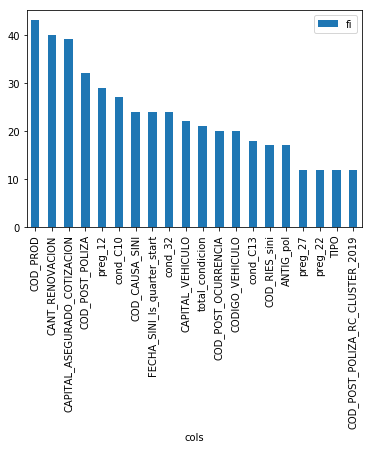

In [141]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [152]:
to_keep = list(rf_fi[rf_fi["fi"] >=5]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 42 of 147


In [153]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

### Training again with less features

In [154]:
X_train_red = X_train[to_keep].copy()
print(len(X_train_red.columns))

42


In [155]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 40},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=11, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [160]:
y_opt_pred = rf.predict_proba(X_opt[to_keep])[:, 1]
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred > 0.5), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.5313725490196078, 0.8439282859583669)

In [161]:
confusion_matrix(y_opt, y_opt_pred> 0.5)

array([[995, 446],
       [ 32, 271]])

In [162]:
predict_proba_range(y_opt_pred)

(-0.01, 0.05]    629
(0.05, 0.1]      135
(0.1, 0.15]       92
(0.15, 0.2]       37
(0.2, 0.25]       26
(0.25, 0.3]       17
(0.3, 0.35]       22
(0.35, 0.4]       23
(0.4, 0.45]       17
(0.45, 0.5]       29
(0.5, 0.55]       32
(0.55, 0.6]       51
(0.6, 0.65]       77
(0.65, 0.7]       62
(0.7, 0.75]       37
(0.75, 0.8]       57
(0.8, 0.85]      130
(0.85, 0.9]      177
(0.9, 0.95]       60
(0.95, 1.0]       34
dtype: int64

**best model**<br>


In [165]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred > 0.3])

EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                17     0     0     0
1               224     0     1     0
2               126     0     0     0
3               276     1     0     0
4                 3     0     0     0
5               207    39     3     3
6                66   482    13   283

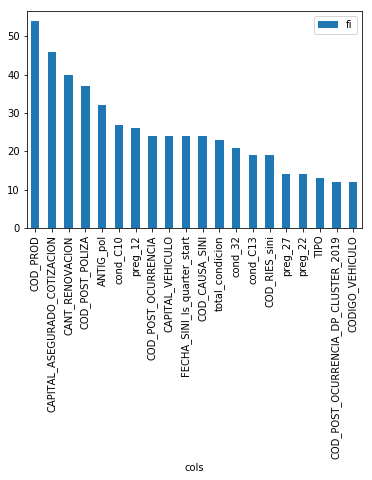

In [166]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [167]:
best_model = copy(rf)

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

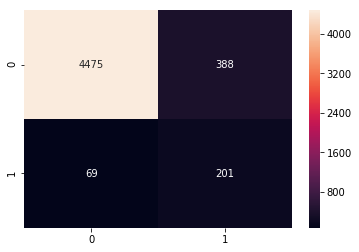

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [168]:
rf_full = copy(best_model)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 40},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=11, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [169]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.472, 0.842


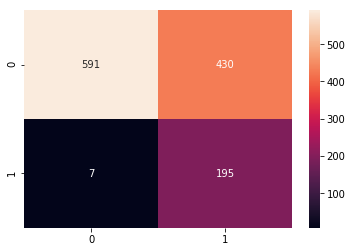

In [170]:
Y_val_adj = y_val_pred_prob > 0.5
conf_mat = confusion_matrix(y_val, Y_val_adj)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [73]:
# 0.471, 0.832
# 580 441 4 198

In [171]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, Y_val_adj])

EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                12     0     0     0
1               159     0     0     0
2               101     0     0     0
3                86     0     0     0
4                 2     0     0     0
5               194    80     4     2
6                37   350     3   193

In [172]:
predict_proba_range(y_val_pred_prob)

(-0.01, 0.05]    211
(0.05, 0.1]      128
(0.1, 0.15]       51
(0.15, 0.2]       29
(0.2, 0.25]       38
(0.25, 0.3]       28
(0.3, 0.35]       36
(0.35, 0.4]       26
(0.4, 0.45]       29
(0.45, 0.5]       22
(0.5, 0.55]       26
(0.55, 0.6]       17
(0.6, 0.65]       13
(0.65, 0.7]       10
(0.7, 0.75]       12
(0.75, 0.8]       19
(0.8, 0.85]       26
(0.85, 0.9]       21
(0.9, 0.95]      160
(0.95, 1.0]      321
dtype: int64

## Tronador (sum cond >=5) comparison

In [86]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3834296724470134,0.6806251878860756)


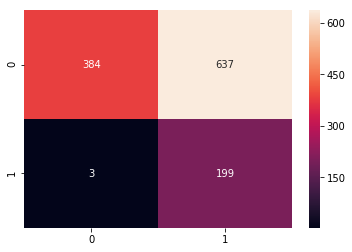

In [87]:
conf_mat = confusion_matrix(y_val, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [88]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_tronador])

EXISTE_FRAUDE   False       True       
total_condicion False True  False True 
TIPO_EXPED                             
0                   9     3     0     0
1                 123    36     0     0
2                  95     6     0     0
3                  86     0     0     0
4                   2     0     0     0
5                  42   232     1     5
6                  27   360     2   194

In [64]:
# use for test without dump  it into disk
m = copy(rf_full)
columns = copy(to_keep)

# Saving final model & columns used into hard drive

In [173]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [174]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [175]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [176]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['COD_PROD', 'CANT_RENOVACION', 'CAPITAL_ASEGURADO_COTIZACION', 'COD_POST_POLIZA', 'preg_12', 'cond_C10', 'COD_CAUSA_SINI', 'FECHA_SINI_Is_quarter_start', 'cond_32', 'CAPITAL_VEHICULO', 'total_condicion', 'COD_POST_OCURRENCIA', 'CODIGO_VEHICULO', 'cond_C13', 'COD_RIES_sini', 'ANTIG_pol', 'preg_27', 'preg_22', 'TIPO', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_ZONA_RC', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'cond_C12', 'FECHA_SINI_Week', 'COD_ZONA_CASCO', 'preg_28', 'preg_37', 'cond_C4', 'CONDICION_ROBO_EXP50', 'OCUPACION_ASEG', 'dias_entre_denu_y_sini', 'COD_RAMO_sini', 'MCA_VIP', 'SEXO', 'FALTANTE', 'preg_32', 'cond_C15', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'FECHA_SINI_Dayofweek', 'COD_COBRO_ANTERIOR']


In [177]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [178]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [179]:
# df_example.head()

# Test prediction

In [180]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [181]:
df_test.shape

(34658, 157)

In [182]:
df_test = df_test[(df_test["total_condicion"] >= 4)]

In [183]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [184]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [185]:
print(columns)

['COD_PROD', 'CANT_RENOVACION', 'CAPITAL_ASEGURADO_COTIZACION', 'COD_POST_POLIZA', 'preg_12', 'cond_C10', 'COD_CAUSA_SINI', 'FECHA_SINI_Is_quarter_start', 'cond_32', 'CAPITAL_VEHICULO', 'total_condicion', 'COD_POST_OCURRENCIA', 'CODIGO_VEHICULO', 'cond_C13', 'COD_RIES_sini', 'ANTIG_pol', 'preg_27', 'preg_22', 'TIPO', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_ZONA_RC', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'cond_C12', 'FECHA_SINI_Week', 'COD_ZONA_CASCO', 'preg_28', 'preg_37', 'cond_C4', 'CONDICION_ROBO_EXP50', 'OCUPACION_ASEG', 'dias_entre_denu_y_sini', 'COD_RAMO_sini', 'MCA_VIP', 'SEXO', 'FALTANTE', 'preg_32', 'cond_C15', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'FECHA_SINI_Dayofweek', 'COD_COBRO_ANTERIOR']


In [186]:
# create cant_cond column
cond_cols = df.filter(regex="^cond_").columns
df_test["cant_cond"] = (df_test[cond_cols] > 0).sum(axis=1)
df_test["cant_cond"].value_counts(dropna=False)

2    389
1     56
3     41
4      3
Name: cant_cond, dtype: int64

In [187]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

## Model in test

In [188]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.489, 0.854


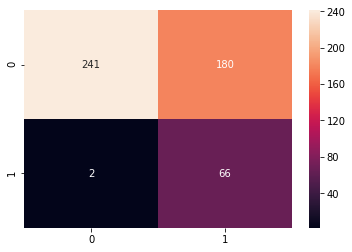

In [193]:
y_prob_adj = y_test_pred_prob > 0.15
conf_mat = confusion_matrix(y_test, y_prob_adj)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [79]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_prob_adj])

EXISTE_FRAUDE False       True 
col_1         False True  True 
TIPO_EXPED                     
0                 5     0     0
1                65     0     0
2                41     0     0
3                34     0     0
5                35    88     5
6                 6   147    63

## Tronador in test

In [71]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.354, 0.705


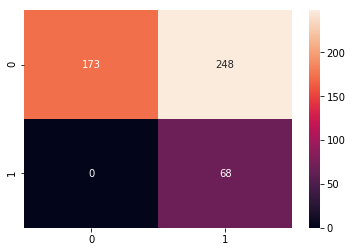

In [72]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [78]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_tronador])

EXISTE_FRAUDE False       True 
es_gte_5      False True  True 
TIPO_EXPED                     
0                 3     2     0
1                54    11     0
2                40     1     0
3                33     1     0
5                26    97     5
6                17   136    63